In [115]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import math
import time
from collections import defaultdict
import itertools

<h2>Task 1: Value Iteration </h2>
A. Enumerate the action space. The coordinates of actions are u = (row; column)

In [ ]:
# this is the set of possible actions admitted in this problem
action_space = [(-1, 0), (0, -1), (1, 0), (0, 1)]
for index, action in enumerate(action_space):
    u_row = action[0]
    u_col = action[1]
    print(f'u{index}:=({u_row};{u_col})')

u0:=(-1;0)
u1:=(0;-1)
u2:=(1;0)
u3:=(0;1)


B. Formulate the optimal cost-to-go G∗ in recursive form. Also formulate how to obtain the optimal policy u∗ from G∗.

+ Formula of the optimal cost-to-go $G^*:$
$$G^*_k(x_k)= min(G^*_{k+1}(f(x_k,u_k))+l(x_k,u_k))$$
where $l(x_k,u_k)$ - cost of traversing from node $x_k$ to $x_{k+1}$ by action $u_k$.  \\
For finite length sequences: 
$$G_F^*(x_F)=l_F(x_F)= \begin{cases}
0 ~~~\text{ if } x_F \in X_G \\
\infty ~\text{ if } x_F \notin X_G
\end{cases} $$ 
where $x_F$ - final state; $X_G$ - goal space 
+ Formula of the optimal policy $u^*$ from $G^*:$
$$u^* = argmin(G^*(f(x,u))+l(x,u)) $$






C. Implement the VI algorithm for infinite length sequences. To show this, you are asked to include a picture of G∗ after convergence. Attach a video of the animation. The cost of traversing each node l(x; u) = 1 only if propagation is possible (there is not obstacle or out of
bounds).

In [56]:
def state_consistency_check(env: np.array, x: Tuple) -> bool:
    """Checks wether or not the proposed state is a valid state, i.e. is in colision or our of bounds"""
    # check for collision
    if x[0] < 0 or x[1] < 0 or x[0] >= env.shape[0] or x[1] >= env.shape[1]:
        return False
    if env[x] >= 1.0 - 1e-4:
        return False
    return True

def pursuer_policy(x_e: Tuple, x_p: Tuple) -> int:
    """Returns the pursuer action"""
    ds = np.array(x_e) - np.array(x_p)
    theta = np.arctan2(ds[1], ds[0])
    theta = (theta + np.pi) / np.pi * 2
    u_index = np.floor(theta)
    delta = theta - u_index
    if np.random.rand() < delta:
        u_index += 1
    if u_index == 4:
        u_index = 0  # this is due to action 0  equals action 4 in this particular order of th action space

    return int(u_index)

def transition_function(env: np.array, x: Tuple, u: Tuple) -> (Tuple, bool):
    xnew = np.array(x) + np.array(u)
    xnew = tuple(xnew)
    if state_consistency_check(env, xnew):
        return xnew, True
    return x, False

In [157]:
def vi(env: np.array, goal: Tuple) -> Tuple[np.array, np.array]:
    policy, cost_to_go = np.zeros(env.shape, 'b'), np.ones(env.shape) * 1e2
    cost_to_go[goal] = 0
    while True:
        is_new = False
        for i in range(len(cost_to_go)):
            for j in range(len(cost_to_go)):
              index = [i,j]
              for act_idx, action in enumerate(action_space):
                  idx, no_collise = transition_function(env, index , action)
                  if no_collise:
                      new_cost = 1 + cost_to_go[idx]
                      if new_cost < cost_to_go[i,j]:
                          is_new = True
                          cost_to_go[i,j] = new_cost
                          policy[i,j] = act_idx
        assert cost_to_go[goal] == 0
        if not is_new:
            break
    return policy, cost_to_go

In [97]:
def plot_joint_enviroment(env: np.array, x_e: Tuple, x_p: Tuple, goal: Tuple) -> np.array:
    current_env = np.copy(env)
    # plot evader
    current_env[x_e] = 0.9  # yellow
    # plot pursuer
    current_env[x_p] = 0.6  # cyan-ish
    # plot goal
    current_env[goal] = 0.3
    return current_env

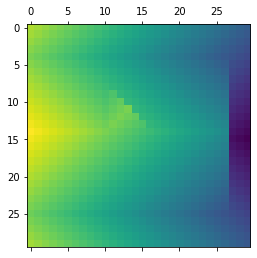

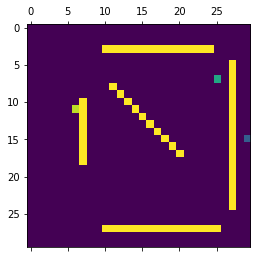

x_e: (15, 28), x_p: (7, 25), distance to goal: 1.00 distance to pursuer: 8.54:  40%|████      | 40/100 [00:00<00:00, 227.43it/s]


WIN!


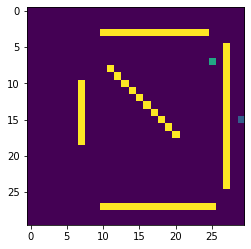

In [125]:
data = np.load('/data_ps3.npz')
environment = data['environment']
# plt.matshow(environment)
# (row index, colum index). In the image row corresponds to y, and colum to x.
x_e = tuple(data["x_e"])  # (11, 6) you free to use it as np array if you prefer, but utils.py is expecting a tuple
x_p = tuple(data["x_p"])  # (7, 25)
goal = tuple(data["goal"])  # (15, 29)
# task 1 VI for evader
# ======================================
default_policy, Gopt = vi(environment, goal)
# visualize the optimal policy
plt.matshow(Gopt)
# Visualization
# ======================================
im = plot_joint_enviroment(environment, x_e, x_p, goal)
plt.matshow(im)
plt.show()
# The Game
fig = plt.figure()
imgs = []
pbar = tqdm(range(100))
for s in pbar:
    im = plot_joint_enviroment(environment, x_e, x_p, goal)
    plot = plt.imshow(im)
    imgs.append([plot])
    # according to the optimal policy of the evader, move the evader
    u_e = action_space[default_policy[x_e]]  # default_policy without taking into account the pursuer
    # u_e = mcts(environment, x_e, x_p, goal, 100, default_policy)  # taking into account pursuer, simulating the game
    x_e, _ = transition_function(environment, x_e, u_e)
    if x_e == goal:
        print('WIN!')
        break
    # propagate the pursuer: TODO uncomment the next line to release the beast
    # x_p = pursuer_transition(environment,x_e, x_p)
    if x_p == x_e:
        print('game over((')
        break
    pbar.set_description(f'x_e: {x_e}, x_p: {x_p},'
                         f' distance to goal: {np.linalg.norm(np.array(x_e) - np.array(goal)):0.2f}'
                         f' distance to pursuer: {np.linalg.norm(np.array(x_e) - np.array(x_p)):0.2f}')
im = plot_joint_enviroment(environment, x_e, x_p, goal)
plot = plt.imshow(im)
imgs.append([plot])
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
ani.save('/escape_vi.mp4')
plt.show()


D. Un-comment the pursuer transition function in line 54. Did you escape?

In [126]:
def pursuer_transition(env: np.array, x_e: Tuple, x_p: Tuple) -> Tuple:
    """
    compact function for the transition function and policy for the pursuer
    5% is the probability of the pursuer to make a double move

    env - enviroment
    x_e - evader state
    x_p - pursuer state
    returns the new state of the pursuer
    """
    iters = 1
    if np.random.rand() < 0.05:
        iters = 2
    for i in range(iters):
        u_p = pursuer_policy(x_e, x_p)
        x_p, _ = transition_function(env, x_p, action_space[u_p])
    return x_p

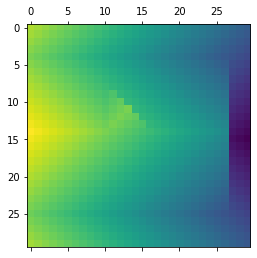

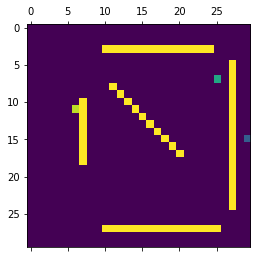

x_e: (4, 15), x_p: (5, 15), distance to goal: 17.80 distance to pursuer: 1.00:  16%|█▌        | 16/100 [00:00<00:00, 242.91it/s]


game over((


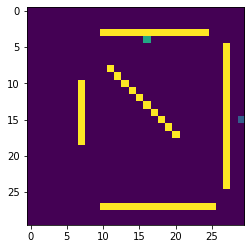

In [127]:
# (row index, colum index). In the image row corresponds to y, and colum to x.
x_e = tuple(data["x_e"])  # (11, 6) you free to use it as np array if you prefer, but utils.py is expecting a tuple
x_p = tuple(data["x_p"])  # (7, 25)
goal = tuple(data["goal"])  # (15, 29)
# task 1 VI for evader
# ======================================
default_policy, Gopt = vi(environment, goal)
# visualize the optimal policy
plt.matshow(Gopt)
# Visualization
# ======================================
im = plot_joint_enviroment(environment, x_e, x_p, goal)
plt.matshow(im)
plt.show()

# The Game
fig = plt.figure()
imgs = []
pbar = tqdm(range(100))
for s in pbar:
    im = plot_joint_enviroment(environment, x_e, x_p, goal)
    plot = plt.imshow(im)
    imgs.append([plot])
    # according to the optimal policy of the evader, move the evader
    u_e = action_space[default_policy[x_e]]  # default_policy without taking into account the pursuer
    x_e, _ = transition_function(environment, x_e, u_e)
    if x_e == goal:
        print('WIN!')
        break
    # propagate the pursuer: TODO uncomment the next line to release the beast
    x_p = pursuer_transition(environment,x_e, x_p)
    if x_p == x_e:
        print('game over((')
        break
    pbar.set_description(f'x_e: {x_e}, x_p: {x_p},'
                         f' distance to goal: {np.linalg.norm(np.array(x_e) - np.array(goal)):0.2f}'
                         f' distance to pursuer: {np.linalg.norm(np.array(x_e) - np.array(x_p)):0.2f}')
im = plot_joint_enviroment(environment, x_e, x_p, goal)
plot = plt.imshow(im)
imgs.append([plot])
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
ani.save('/escape_vi1.mp4')
plt.show()

No, I did not escape

<h2> Task 2: Monte Carlo Tree Search </h2>

A. Why do you think we have proposed the restriction of expanding only non-visited states?

The restriction of expanding only non-visited states have been proposed because we couldn't ensure that the policy tree would expand appropriately with a restricted amount of samples.

B. Implement MCTS.

In [156]:
class State:
	def __init__(self,x_e,x_p,turn,goal,is_expanded=False,is_simulated=False, parent=None):
		self.evader = x_e
		self.pursuer = x_p
		self.turn = turn
		self.goal = goal
		self.is_expanded = is_expanded
		self.is_simulated = is_simulated
		self.visited = 0
		self.reward = 0
		self.parent = parent
		self.children = 0
		self.is_terminal = self.evader == self.goal
	def __str__(self):
		return f"""evader={self.evader}, pursuer={self.pursuer}, turn={self.turn},
		{self.is_expanded =},{self.is_simulated =}, {self.visited =}, reward={self.reward}"""
	def get_action(self, root):
		action = tuple(np.array(self.evader)-np.array(root.evader))
		assert action in action_space, f'{action}'
		return action
	def get_location(self):
		return [self.evader,self.pursuer,self.turn]

def unexplored_node(env, node, Tree):
	if len(Tree[node]) == 0:
		return True
	for child in Tree[node]:
		if child.is_simulated == False:
			return True
	return False

def get_children(env,state,discovered_nodes):
		assert state.children == 0
		if state.evader == state.goal:
			return []
		children =[]
		for action in action_space:
			if state.turn == 'evader':
				node = state.evader
			elif state.turn == 'pursuer':
				node = state.pursuer
			may_child, is_child = transition_function(env, node, action)
			if is_child:
				if state.turn == 'evader':
					child_state = State(may_child,state.pursuer,'pursuer',state.goal,parent=state)
				elif state.turn == 'pursuer':
					child_state = State(state.evader,may_child,'evader',state.goal,parent=state)
				if child_state.get_location() not in discovered_nodes:
					children.append(child_state)
		state.children = len(children)
		return children

def expand(env, node, Tree, discovered_nodes):
	if not node.is_expanded:
		children = get_children(env, node, discovered_nodes)
		Tree[node] = children
		discovered_nodes.extend([child.get_location() for child in children])
		node.is_expanded = True

def child_select(node, Tree, weight=2**0.5):
		children = Tree[node]
		assert all(child.is_simulated for child in children)
		vertex = math.log(node.visited)
		def bound(child):
				return child.reward / child.visited + weight * (vertex / child.visited)**0.5
		return max(children, key=bound)

def simulation(x_e=x_e, x_p=x_p, turn:str='evader', policy=default_policy):
    accumulated_reward = 0
    for s in range(100):
        distance_to_goal = np.linalg.norm(np.array(x_e) - np.array(goal))
        if distance_to_goal != 0:
            accumulated_reward += 0.1/distance_to_goal
        else:
            accumulated_reward += 100
        # according to the optimal policy of the evader, move the evader
        u_e = action_space[policy[x_e]]  # default_policy without taking into account the pursuer
        if not (s == 0 and turn=='pursuer'):
            x_e, _ = transition_function(environment, x_e, u_e)
        
        if x_e == goal:
            return 100 + accumulated_reward - (s+1)

        # propagate the pursuer: TODO uncomment the next line to release the beast
        x_p = pursuer_transition(environment,x_e, x_p)
        if x_p == x_e:
            return 0
    return accumulated_reward

def re_simulation(node, policy):
	return simulation(node.evader, node.pursuer, node.turn, policy)

def is_root(node):
	return node.parent is None

def backpropagate(node, reward):
	node.visited += 1
	node.reward += reward
	if node.parent is None: return
	backpropagate(node.parent, reward)

def best_child(node, Tree):
	children = Tree[node]
	def visits(child):
		return child.visited
	return max(children.visited)

def plot_explored(env, Tree, node):
	current_env = np.copy(env)
	for node_ in Tree.keys():
		children = Tree[node_]
		evaders = [child.evader for child in children]+[node_.evader]
		pursuers = [child.pursuer for child in children]+[node_.pursuer]
		goal = node_.goal
		for evader in evaders:
			current_env[evader] = 0.9  # yellow
		current_env[node.evader] = 1
		# plot pursuer
		for pursuer in pursuers:
			current_env[pursuer] = 0.6  # cyan-ish
		current_env[node.pursuer] = 0.4  # cyan-ish
		# plot goal
		current_env[goal] = 0.3
	plt.close()
	fig = plt.figure()
	ax = fig.gca()
	ax.pcolormesh(current_env, edgecolors='k', linewidth=1)
	ax.set_aspect('equal')
	ax.invert_yaxis()
	plt.show()

In [154]:
def mcts(env: np.array, x_e: Tuple, x_p: Tuple, goal: Tuple, k: int, default_policy) -> Tuple:
	"""
	Monte-Carlo tree search
	env is the grid enviroment
	x_e evader
	x_p pursuer
	goal is the goal state
	u is an optimal action
	"""
	Tree = defaultdict(list)
	root = State(x_e, x_p,'evader', goal, False)
	discovered_nodes = [root.get_location()]
	expand(env, root, Tree, discovered_nodes)
	for child in Tree[root]:
		if child.is_terminal:
			return child.get_action(root)
	pbar = tqdm(total=k, desc='inner_loop', leave=False)
	while k > 0:
		node = root
		while not unexplored_node(env, node, Tree):
			node = child_select(node,Tree)
		if node.visited != 0 or is_root(node) : # or not node.is_simulated i guess
			expand(env, node, Tree, discovered_nodes)
			not_explored_children = [child for child in Tree[node] if child.visited == 0]
			if len(not_explored_children) != 0:
				node = np.random.choice(not_explored_children)
		reward = re_simulation(node, default_policy)
		node.is_simulated = True
		backpropagate(node, reward)
		k-=1
		pbar.update(1)
	u = best_child(root,Tree).get_action(root)
	return u


inner_loop:   0%|          | 0/100 [00:00<?, ?it/s]
                                                   

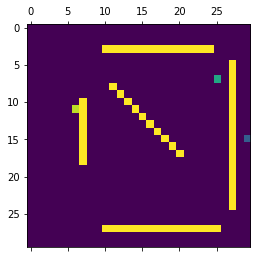


  0%|          | 0/100 [00:00<?, ?it/s]

inner_loop:   0%|          | 0/100 [00:00<?, ?it/s]

inner_loop:  84%|████████▍ | 84/100 [00:00<00:00, 834.53it/s]

                                                             
x_e: (12, 6), x_p: (7, 24), distance to goal: 23.19 distance to pursuer: 18.68:   0%|          | 0/100 [00:00<?, ?it/s]
x_e: (12, 6), x_p: (7, 24), distance to goal: 23.19 distance to pursuer: 18.68:   1%|          | 1/100 [00:00<00:17,  5.66it/s]

inner_loop:   0%|          | 0/100 [00:00<?, ?it/s]

                                                   
x_e: (11, 6), x_p: (7, 23), distance to goal: 23.35 distance to pursuer: 17.46:   1%|          | 1/100 [00:00<00:17,  5.66it/s]
x_e: (11, 6), x_p: (7, 23), distance to goal: 23.35 distance to pursuer: 17.46:   2%|▏         | 2/100 [00:00<00:14,  6.81it/s]

inner_loop:   0%|          | 0/100 [00:00<?, ?it/s]

inner_loop:  77%|███████▋  | 77/100 [00:00<00:00, 762.71it/s]

                                                     

WIN!


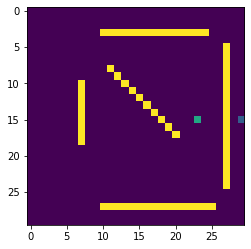

In [155]:
# (row index, colum index). In the image row corresponds to y, and colum to x.
x_e = tuple(data["x_e"])  # (11, 6) you free to use it as np array if you prefer, but utils.py is expecting a tuple
x_p = tuple(data["x_p"])  # (7, 25)
goal = tuple(data["goal"])  # (15, 29)

# task 1 VI for evader
# ======================================
default_policy, Gopt = vi(environment, goal)

# visualize the optimal policy
#plt.matshow(Gopt)

# task2 MCTS
# ======================================
u = mcts(environment, x_e, x_p, goal, 100, default_policy)  # here is just to check

# Visualization
# ======================================
im = plot_joint_enviroment(environment, x_e, x_p, goal)
plt.matshow(im)
plt.show()

# The Game
fig = plt.figure()
imgs = []
pbar = tqdm(range(100))
for s in pbar:
    im = plot_joint_enviroment(environment, x_e, x_p, goal)
    plot = plt.imshow(im)
    imgs.append([plot])
    # according to the optimal policy of the evader, move the evader
    #u_e = action_space[default_policy[x_e]]  # default_policy without taking into account the pursuer
    u_e = mcts(environment, x_e, x_p, goal, 100, default_policy)  # taking into account pursuer, simulating the game
    x_e, _ = transition_function(environment, x_e, u_e)
    if x_e == goal:
        print('WIN!')
        break
    # propagate the pursuer: TODO uncomment the next line to release the beast
    x_p = pursuer_transition(environment,x_e, x_p)
    if x_p == x_e:
        print('game over((')
        break
    pbar.set_description(f'x_e: {x_e}, x_p: {x_p},'
                         f' distance to goal: {np.linalg.norm(np.array(x_e) - np.array(goal)):0.2f}'
                         f' distance to pursuer: {np.linalg.norm(np.array(x_e) - np.array(x_p)):0.2f}')
im = plot_joint_enviroment(environment, x_e, x_p, goal)
plot = plt.imshow(im)
imgs.append([plot])
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
ani.save('/escape_mcts.mp4')
plt.show()